In [1]:
import os
import math
import re
import json

import random

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer

# from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

c:\users\yasht\fakenews\venv\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
%matplotlib inline
random.seed(1)
np.random.seed(1)

In [3]:
w2v_model_file = 'imdb_review_w2v.model' # change each time
d2vdm_model_file = 'imdb_review_d2vdm.model' # change each time
d2vdbow_model_file = 'imdb_review_d2vdbow.model' # change each time
train_csv = 'train_df.csv'
test_csv = 'test_df.csv'
df_csv = 'df.csv'
df_pkl = 'df.pkl'

neg_bound = 4
pos_bound = 7

train_size = 0.80

num_reviews = 10000
doc_ids = np.asarray(range(num_reviews))

min_occ = 5 # The minimum number of occurrences for a word to be considered

In [4]:
def get_w2v_vector(word):
    """Get the vector for a word"""
    try:
        return model.wv[word]
    except:
        print(word)
        raise
        
def filter_tokens(tokens, vocab=None):
    if vocab is None:
        vocab = w2v_vocab
    return [token for token in tokens if token in vocab]

In [5]:
en_stop = set(nltk.corpus.stopwords.words('english'))
stemmer = WordNetLemmatizer()

def tokenize(text):
    text = text.lower()
    # Remove non-word characters
    text = re.sub(r'[^a-z]', ' ', text)
    # Remove single letters
    text = re.sub(r'\b[a-z]{0,3}\b', ' ', text)
    # Merge multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Lemmatization
    tokens = text.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    
    return tokens

In [6]:
def split_stratified(X, labels):
    return train_test_split(X, stratify=labels, train_size=train_size, random_state=1)

def my_train_test_split(X):
    return split_stratified(X, df['Rating'])

# Run once

In [65]:
half_reviews = num_reviews // 2
assert half_reviews == num_reviews / 2

def load_train_or_test(dir):
    random.seed(3)
    """
    Return the negative and positive train or test data
    """
    def load_neg_or_pos(sub, is_pos):
        res = []
        for file_name in os.listdir(sub):
            with open(sub + file_name, encoding='utf8') as file:
                underscore_ind = file_name.index('_')
                period_ind = file_name.index('.')
                id = int(file_name[:underscore_ind])
                rating = int(file_name[underscore_ind + 1:period_ind])
                text = next(file)
                res.append([rating, text])
        return res
    # Only choose more polar ratings
    neg = [[rating, text] for rating, text in load_neg_or_pos(dir + '/neg/', False) if rating <= neg_bound]
    pos = [[rating, text] for rating, text in load_neg_or_pos(dir + '/pos/', True) if rating >= pos_bound]
    random.shuffle(neg)
    random.shuffle(pos)
    both = neg[:half_reviews] + pos[:half_reviews]
    random.shuffle(both)
    return pd.DataFrame(both, columns=['Rating', 'Text'])

In [66]:
df = load_train_or_test('./train') #.append(load_train_or_test('./test'))

In [67]:
df

Rating                                               Text
0         10  this may not be War & Peace, but the two Acade...
1         10  after seeing this film for the 3rd time now i ...
2          1  When 'My Deja Vu, My Deja Vu' aired last seaso...
3         10  "Magic" isn't too strong a word for the spell ...
4         10  You could stage a version of Charles Dickens' ...
...      ...                                                ...
9995       8  Judy Davis shows us here why she is one of Aus...
9996       2  Don't get me wrong, I love action and revenge ...
9997       8  Im a huge M Lillard fan that's why I ended up ...
9998       8  In Iran women are prohibited from attending li...
9999       4  The movie had a cute opening, I truly believed...

[10000 rows x 2 columns]

In [68]:
df['Tokens'] = df['Text'].apply(tokenize)
# Clean up the text too
df['Text'] = df['Tokens'].apply(" ".join)

In [69]:
df

Rating                                               Text  \
0         10  peace academy noms forthcoming genius james wo...   
1         10  seeing film time think almost adam worst film ...   
2          1  deja deja aired last season pleased scrub thou...   
3         10  magic strong word spell film weave find relaxi...   
4         10  could stage version charles dickens christmas ...   
...      ...                                                ...   
9995       8  judy davis show australia respected loved acto...   
9996       2  wrong love action revenge flick seen many sinc...   
9997       8  huge lillard ended watching movie honestly dou...   
9998       8  iran woman prohibited attending live sporting ...   
9999       4  movie cute opening truly believed best romanti...   

                                                 Tokens  
0     [peace, academy, noms, forthcoming, genius, ja...  
1     [seeing, film, time, think, almost, adam, wors...  
2     [deja, deja, aired, last, season, pleased, scr...  
3     [magic, strong, word, spell, film, weave, find...  
4     [could, stage, version, charles, dickens, chri...  
...                                                 ...  
9995  [judy, davis, show, australia, respected, love...  
9996  [wrong, love, action, revenge, flick, seen, ma...  
9997  [huge, lillard, ended, watching, movie, honest...  
9998  [iran, woman, prohibited, attending, live, spo...  
9999  [movie, cute, opening, truly, believed, best, ...  

[10000 rows x 3 columns]

In [70]:
# Save processed data
# df.to_csv(df_csv)
df.to_pickle(df_pkl)

In [71]:
# # Train and save model
train_tokens, test_tokens = my_train_test_split(df['Tokens'])
w2v_model = Word2Vec(sentences=train_tokens)
w2v_model.save(w2v_model_file)

In [73]:
w2v_vocab = set(w2v_model.wv.key_to_index.keys())
w2v_vocab_ord = np.array(list(w2v_model.wv.key_to_index.keys()))

In [74]:
# # Keep only tokens that showed up the required number of times
# train_df['Tokens'] = train_df['Tokens'].apply(filter_tokens)

# test_df['Tokens'] = test_df['Text'].apply(lambda text: filter_tokens(tokenize(text)))
# # Process test text too
# test_df['Text'] = test_df['Tokens'].apply(" ".join)

In [75]:
# # The vectors corresponding to each reviews' words
# df['Vectors'] = df['Tokens'].apply(get_vector)

In [83]:
# Train Doc2Vec model
import collections
from gensim.models.callbacks import CallbackAny2Vec

tagged_docs = [TaggedDocument(words=df['Tokens'][doc_id], tags=[doc_id]) for doc_id in doc_ids]
assert type(tagged_docs[0].words) == list
# print(len(tagged_docs), type(tagged_docs[0].words), tagged_docs[0])
X_train_docs, X_test_docs = my_train_test_split(tagged_docs)

class PrintLoss(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    
    def on_epoch_begin(self, model):
        model.running_training_loss = 0.0
#         print(f'Starting epoch {self.epoch}', end=' | ')
    
    def on_epoch_end(self, model):
#         print(f'Finished epoch {self.epoch}, loss = {model.get_latest_training_loss()}')
        self.epoch += 1

def train_d2v(model):
    model.random.seed(1)
    model.build_vocab(X_train_docs)
    model.train(X_train_docs, total_examples=model.corpus_count, epochs=model.epochs, compute_loss=True, callbacks=[PrintLoss()])
    return model

In [84]:
d2vdm_model = train_d2v(Doc2Vec(dm=1, vector_size=50, min_count=min_occ, epochs=100, seed=1))
d2vdm_model.save(d2vdm_model_file)
print('Trained d2vdm')

d2vdbow_model = train_d2v(Doc2Vec(dm=0, vector_size=50, min_count=min_occ, epochs=100, seed=1))
d2vdbow_model.save(d2vdbow_model_file)
print('Trained d2vdbow')

Trained d2vdm
Trained d2vdbow


In [85]:
d2vdm100_model = train_d2v(Doc2Vec(dm=1, vector_size=100, min_count=min_occ, epochs=100, seed=1))
d2vdm100_model.save('d2vdm100.model')
print('Trained d2vdm')

d2vdbow100_model = train_d2v(Doc2Vec(dm=0, vector_size=100, min_count=min_occ, epochs=100, seed=1))
d2vdbow100_model.save('d2vdbow100.model')
print('Trained d2vdbow')

Trained d2vdm
Trained d2vdbow


In [79]:
def get_d2v_sim(model, doc1, doc2):
    """Get cos similarity of 2 docs' vectors"""
    vector1 = model.infer_vector(doc1)
    vector2 = model.infer_vector(doc2)
    return cosine_similarity([vector1], [vector2])

In [17]:
sim_reviews = df[df['Tokens'].apply(lambda x: 'bromwell' in x)]
sim_reviews

Rating                                               Text  \
55         9  bromwell high cartoon comedy time program scho...   
1298       9  bromwell high nothing short brilliant expertly...   

                                                 Tokens  
55    [bromwell, high, cartoon, comedy, time, progra...  
1298  [bromwell, high, nothing, short, brilliant, ex...

In [23]:
r1, r2 = sim_reviews.Tokens
get_d2v_sim(d2vdm_model, r1, r2)

array([[0.62547696]], dtype=float32)

In [24]:
get_d2v_sim(d2vdbow_model, r1, r2)

array([[0.44448546]], dtype=float32)

In [ ]:
s1.min(), s1.max(), s1.mean(), np.median(s1), s1.min(), s2.max(), s2.mean(), np.median(s2)

# Load stuff done already

In [7]:
# df = pd.read_csv(df_csv)
df = pd.read_pickle(df_pkl)

In [8]:
# Load pretrained Word2Vec model
w2v_model = Word2Vec.load(w2v_model_file)

In [9]:
# Load pretrained Doc2Vec models
d2vdm_model = Doc2Vec.load(d2vdm_model_file)
d2vdbow_model = Doc2Vec.load(d2vdbow_model_file)
d2vdm100_model = Doc2Vec.load('d2vdm100.model')
d2vdbow100_model = Doc2Vec.load('d2vdbow100.model')

# Common stuff

In [10]:
w2v_vocab = set(w2v_model.wv.key_to_index.keys())
w2v_vocab_ord = np.array(list(w2v_model.wv.key_to_index.keys()))

In [11]:
# y_bin2 = df['Rating'] // 2
# y_train_bin2, y_test_bin2 = split_stratified(y_bin2, y_bin2)

# Classifiers

In [58]:
y_bi = df['Rating'] > 5
y_train_bi, y_test_bi = my_train_test_split(y_bi)

In [14]:
classifier_results = dict()

def score_classifier(classifier, X_test, y_test=y_test_bi, big_table=True):
    score = classifier.score(X_test, y_test)
    predicted = classifier.predict(X_test)
    cm = confusion_matrix(predicted, y_test)
    report = classification_report(predicted, y_test)
    
    classifier_results[str(classifier)] = (score, cm)
    
    print_results(score, cm, report, big_table)
    
def print_results(score, cm, class_report, big_table=True):
    print('Mean accuracy:', score)
    print(f"TP: {cm[0][0]}, FN: {cm[0][1]}\nFP: {cm[1][0]}, TN: {cm[1][1]}")
    if big_table:
        print(class_report)

In [15]:
def try_classifier(classifier, X_train, X_test, big_table=True):
    classifier.fit(X_train, y_train_bi)
    score_classifier(classifier, X_test, big_table=big_table)

def try_tfidf_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_tfidf, X_test_tfidf, big_table=big_table)

def try_d2vdm_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdm, X_test_d2vdm, big_table=big_table)
    
def try_d2vdbow_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdbow, X_test_d2vdbow, big_table=big_table)
    
def try_d2vdm100_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdm100, X_test_d2vdm100, big_table=big_table)
    
def try_d2vdbow100_classifier(classifier, big_table=True):
    try_classifier(classifier, X_train_d2vdbow100, X_test_d2vdbow100, big_table=big_table)

In [16]:
# Make different train-test splits for tf-idf
def make_tfidf(**kwargs):
    # en_stop because the default apparently has problems
    tfidf_vectorizer = TfidfVectorizer(stop_words=en_stop, min_df=min_occ, **kwargs)
    X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])
    X_train_tfidf, X_test_tfidf = my_train_test_split(X_tfidf)
    
    print(X_train_tfidf.shape, len(tfidf_vectorizer.vocabulary_.keys()))
    
    return X_train_tfidf, X_test_tfidf

X_train_tfidf_1, X_test_tfidf_1 = make_tfidf(ngram_range=(1, 1))
X_train_tfidf_1_2, X_test_tfidf_1_2 = make_tfidf(ngram_range=(1, 2))
X_train_tfidf_2, X_test_tfidf_2 = make_tfidf(ngram_range=(2, 2))

# The "best" tf-idf model
X_train_tfidf = X_train_tfidf_1_2

(8000, 14577) 14577
(8000, 33867) 33867
(8000, 19290) 19290


In [17]:
# Make different train-test splits for Doc2Vec
def split_d2v(model):
    vectors = df['Tokens'].apply(model.infer_vector)
    train, test = my_train_test_split(vectors)
    return np.stack(train), np.stack(test)

X_train_d2vdm, X_test_d2vdm = split_d2v(d2vdm_model)
X_train_d2vdbow, X_test_d2vdbow = split_d2v(d2vdbow_model)
X_train_d2vdm100, X_test_d2vdm100 = split_d2v(d2vdm100_model)
X_train_d2vdbow100, X_test_d2vdbow100 = split_d2v(d2vdbow100_model)

In [18]:
X_test_d2vdm = np.stack(X_test_d2vdm)

In [57]:
# Make different train-test splits for Doc2Vec
        
def make_w2v(model):
    """Average vectors in doc, then train-test split"""
    
    def average_doc_w2v_vectors(doc):
        """Average Word2Vec vectors of document"""
        sum_vec = None
        num = 0
        for word in doc:
            if sum_vec is None:
                sum_vec = np.zeros(model.vector_size)
                num += 1
            elif word in model.wv.key_to_index:
                sum_vec += model.wv[word]
                num += 1
        if num:
            return sum_vec / num
        else:
            raise
#             return np.zeros(w2v_model.vector_size)
    
    averaged = df['Tokens'].apply(average_doc_w2v_vectors)
    
    return my_train_test_split(np.stack(averaged))

X_train_w2vavg, X_test_w2vavg = make_w2v(w2v_model)

# t-SNE

In [155]:
from sklearn.manifold import TSNE

sentiment_cmap = matplotlib.colors.ListedColormap(['red', 'blue'])

def try_d2v_tsne(X_tsne, size_2d=(15, 15)):
#     cm = plt.cm.get_cmap('gist_rainbow')
    font_size = 'x-large'
    
    transposed = X_tsne.transpose()
    xs, ys = transposed
    
    fig = plt.figure(figsize=size_2d)
    ax = plt.axes()
    # Plot each word, with the third feature being 
    plot = plt.scatter(xs, ys, c=y_train_bi, cmap=sentiment_cmap)
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
#     ax.set_xlim(xlim[0], xlim[1])
#     ax.set_ylim(ylim[0], ylim[1])

    plt.show()
    
from sklearn.manifold import TSNE

def try_d2v_tsne_3d(X_tsne, size_3d=(15, 15), xlim=(-150, 300), ylim=(-600, 250), zlim=(-150, 300)):
    font_size = 'x-large'
    
    transposed = X_tsne.transpose()
    xs, ys, zs = transposed
    neg_xs = []
    neg_ys = []
    neg_zs = []
    pos_xs = []
    pos_ys = []
    pos_zs = []
    
    for x, y, z, res in zip(xs, ys, zs, y_train_bi):
        _xs, _ys, _zs = [pos_xs, pos_ys, pos_zs] if res else [neg_xs, neg_ys, neg_zs]
        _xs.append(x)
        _ys.append(y)
        _zs.append(z)
    
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    # Red is for negative reviews, blue is for positive ones
    plot = ax.scatter(xs, ys, zs, c=y_train_bi, cmap=sentiment_cmap)
    
#     plt.colorbar(plot)

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    # Just plot negative reviews
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    plot = ax.scatter(neg_xs, neg_ys, neg_zs, c='red')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()
    
    # Just plot positive reviews
    fig = plt.figure(figsize=size_3d)
    ax = plt.axes(projection='3d')
    plot = ax.scatter(pos_xs, pos_ys, pos_zs, c='blue')

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])

    plt.show()

In [36]:
X_tsne_d2vdm2d = TSNE(n_components=2).fit_transform(X_train_d2vdm)

In [37]:
X_tsne_d2vdm3d = TSNE(n_components=3).fit_transform(X_train_d2vdm)

In [66]:
X_tsne_d2vdm3d100 = TSNE(n_components=3).fit_transform(X_train_d2vdm100)

In [38]:
X_tsne_d2vdbow2d = TSNE(n_components=2).fit_transform(X_train_d2vdbow)

In [39]:
X_tsne_d2vdbow3d = TSNE(n_components=3).fit_transform(X_train_d2vdbow)

In [ ]:
X_tsne_d2vdbow3d100 = TSNE(n_components=3).fit_transform(X_train_d2vdbow100)

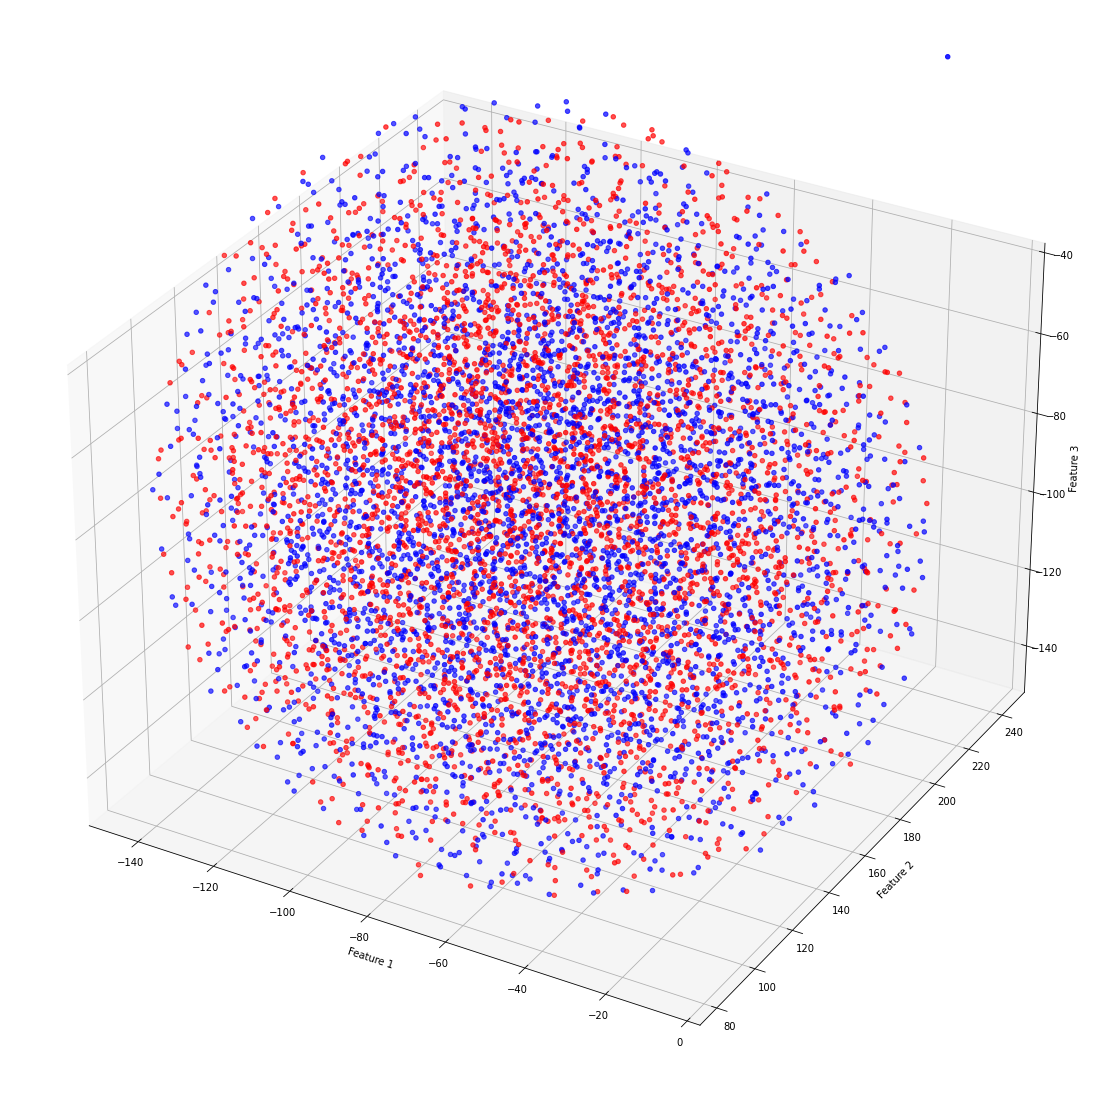

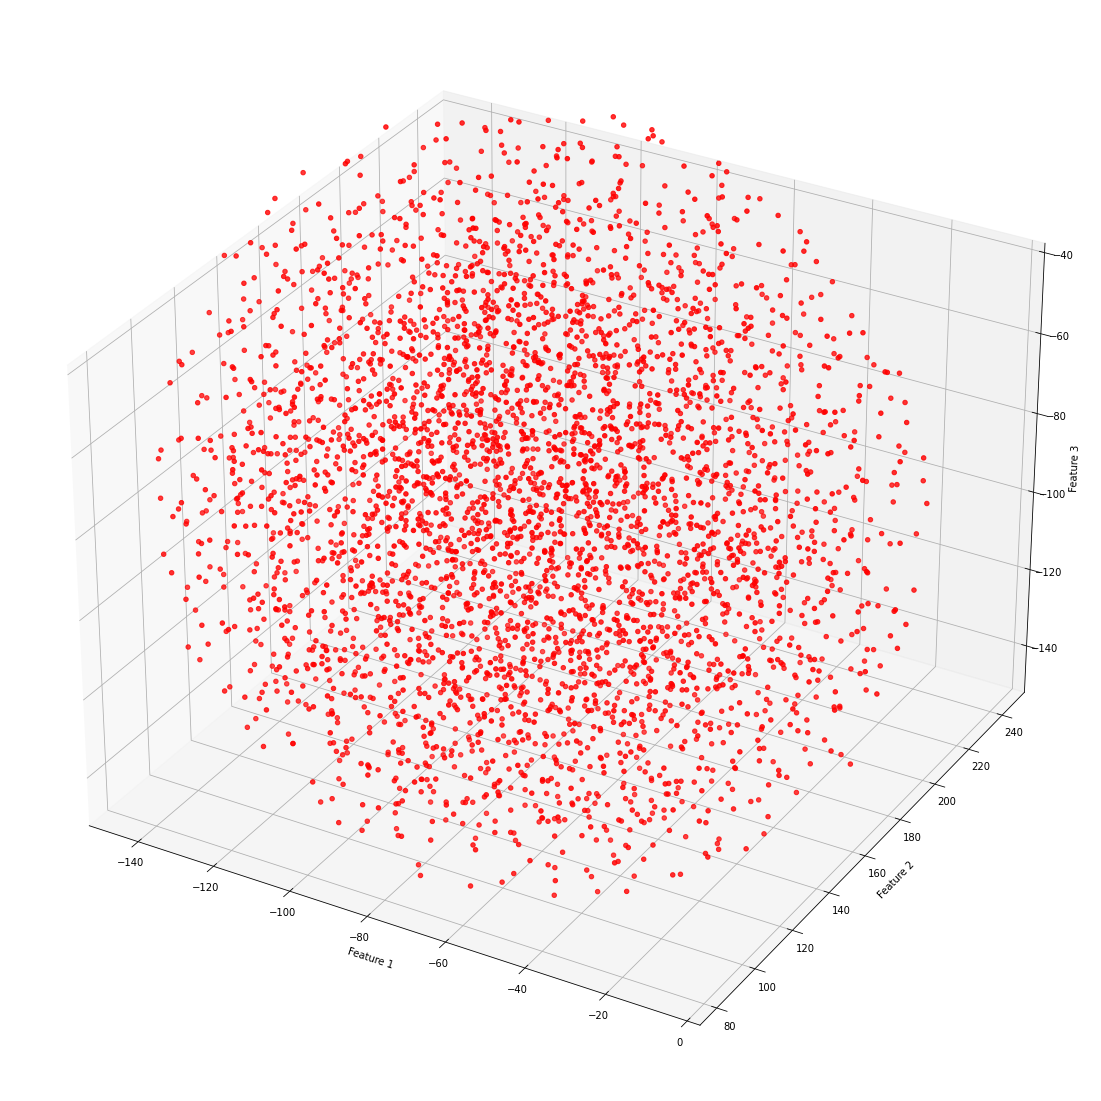

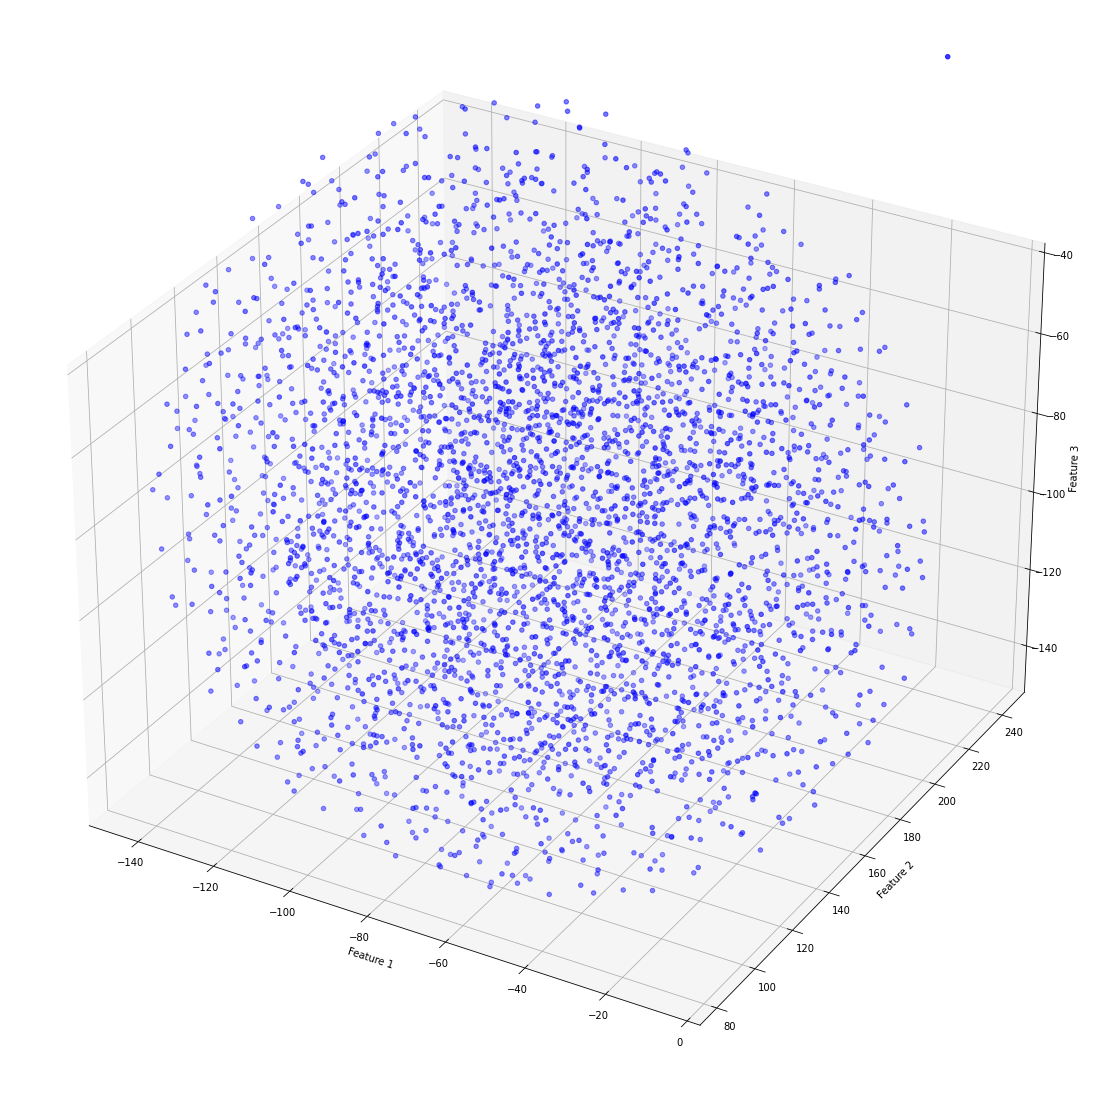

In [68]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdm3d100, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

In [ ]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdbow3d100, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

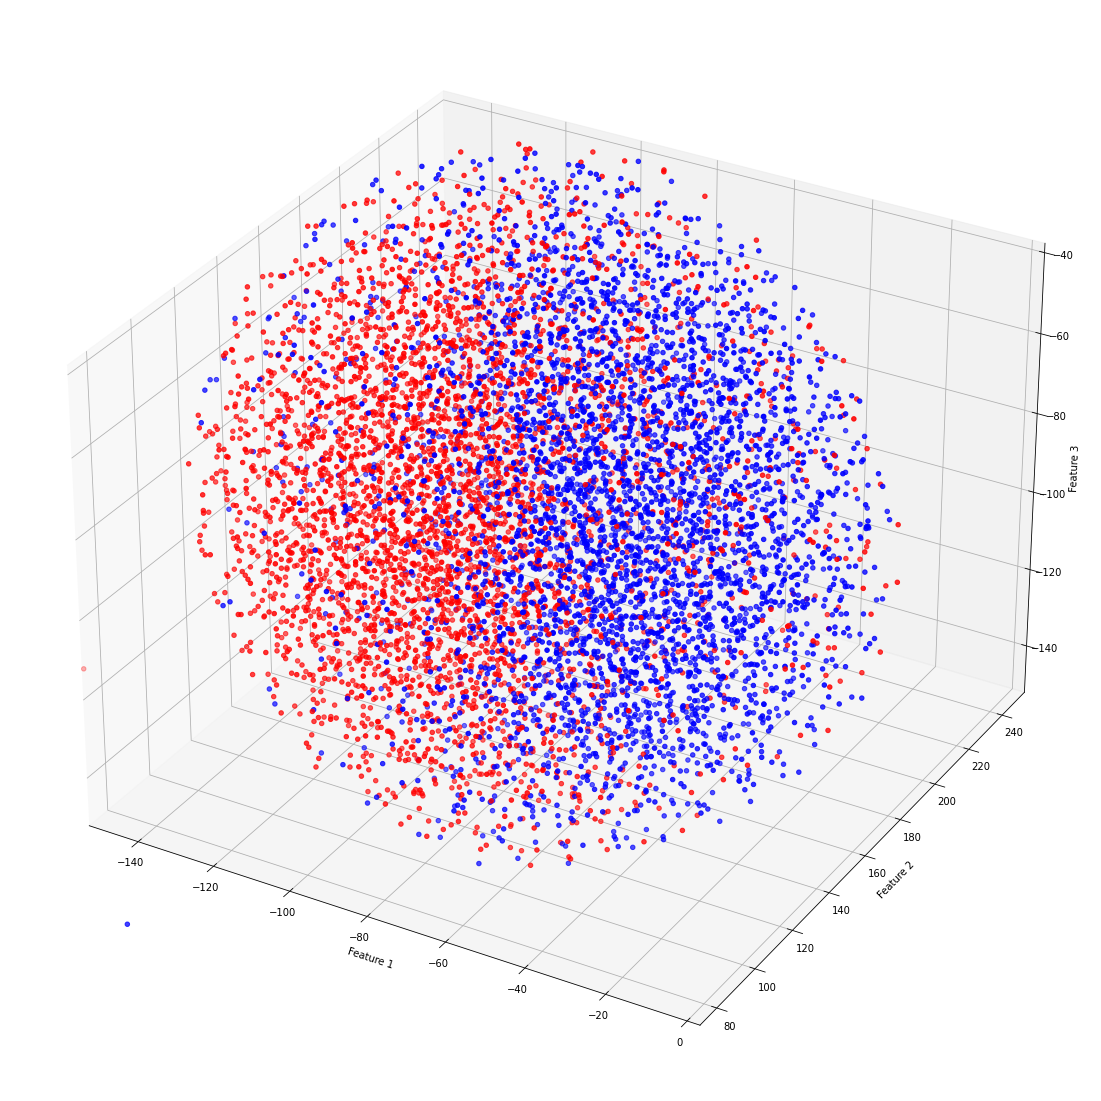

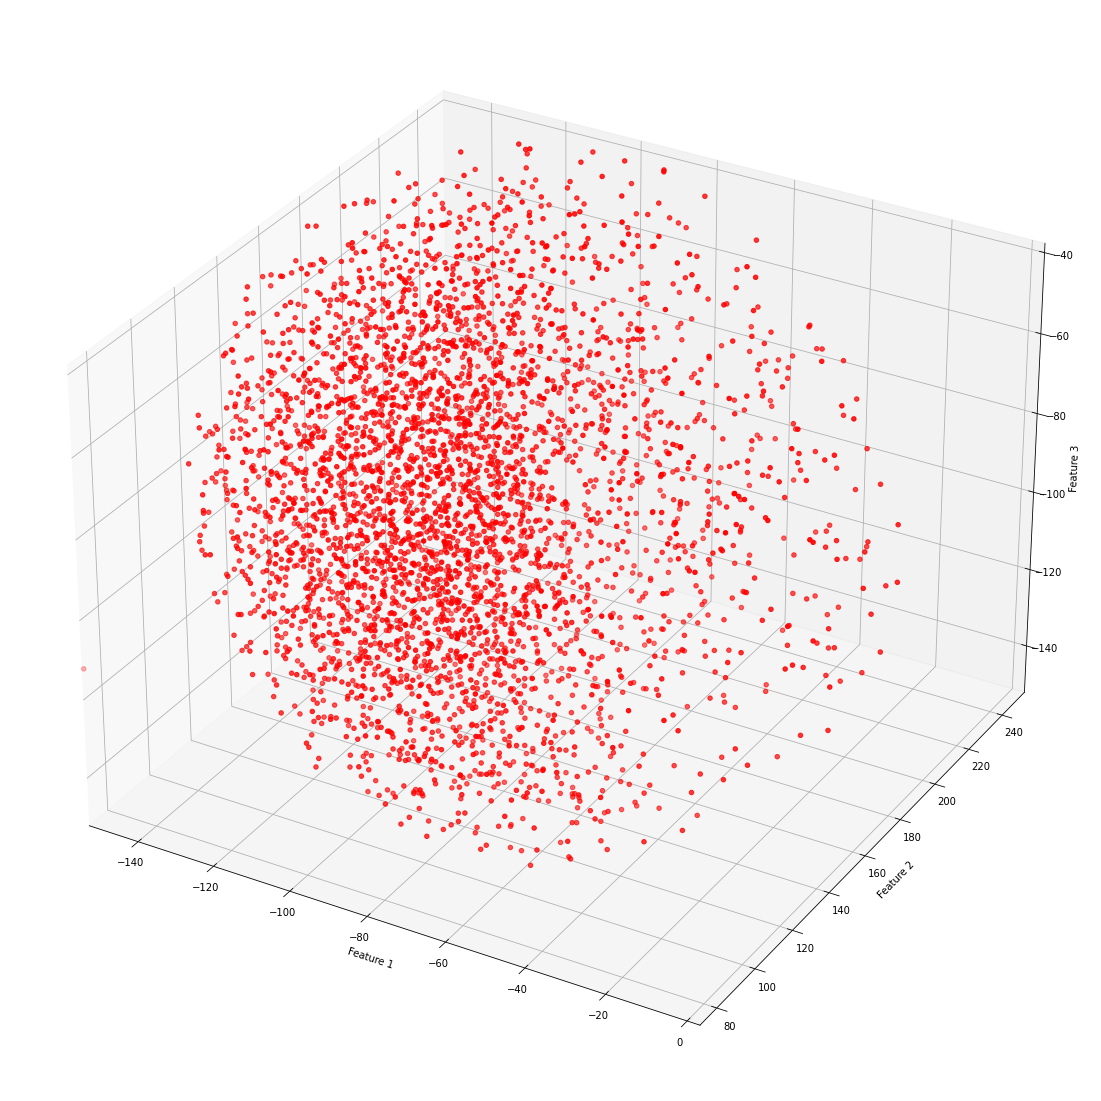

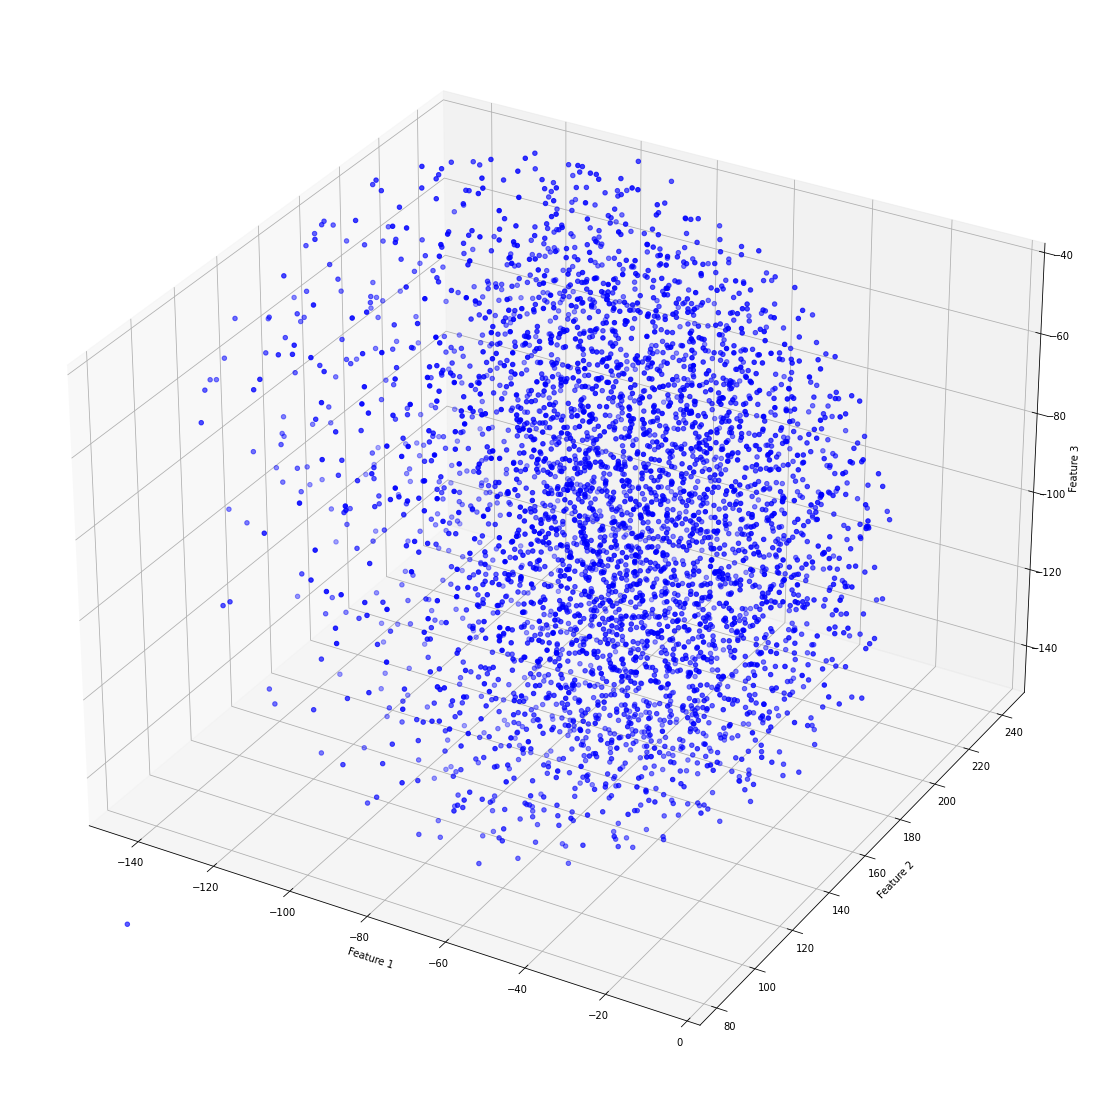

In [50]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdm3d, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -40), size_3d=(20, 20))

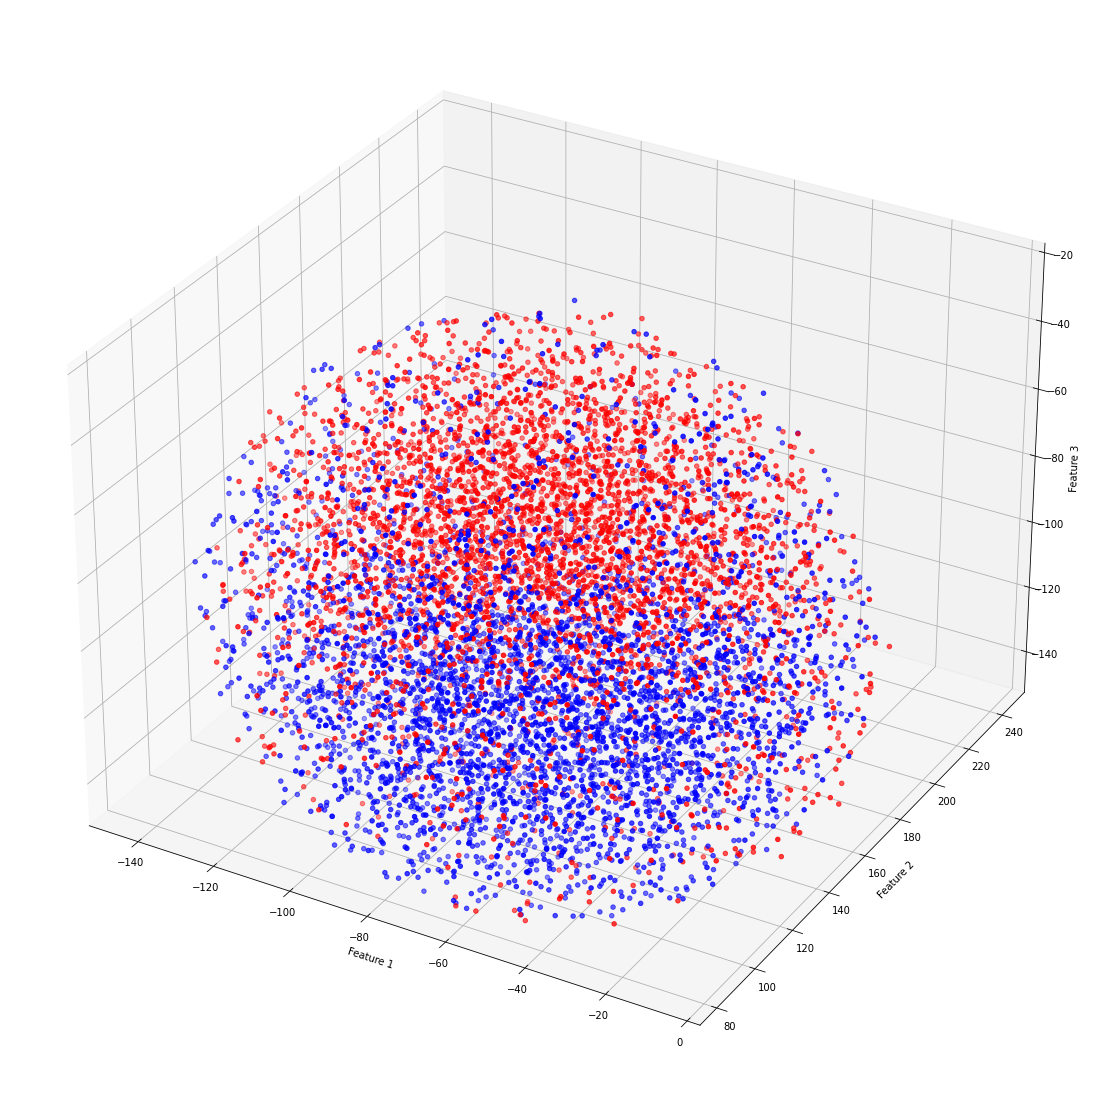

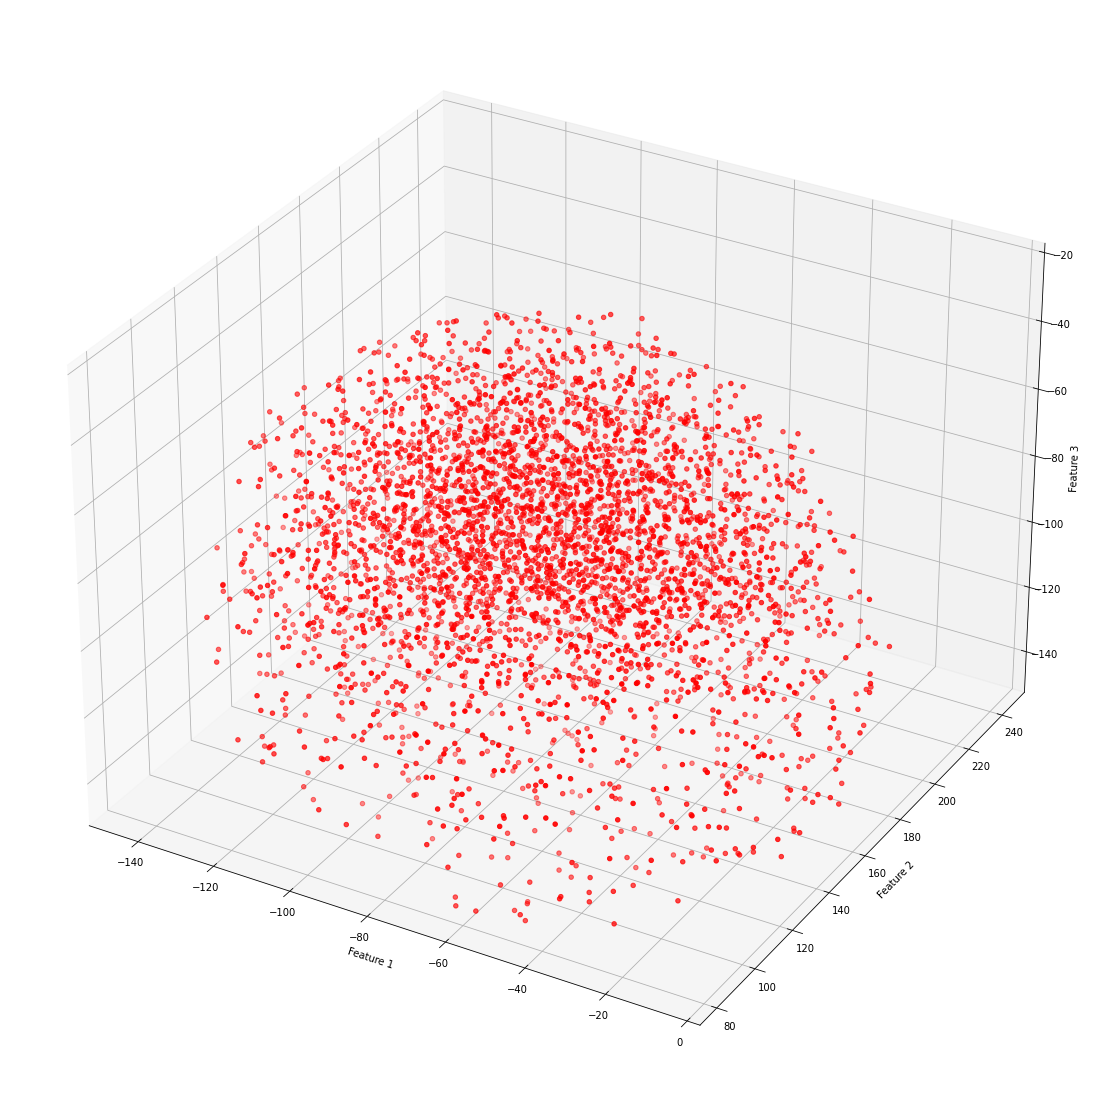

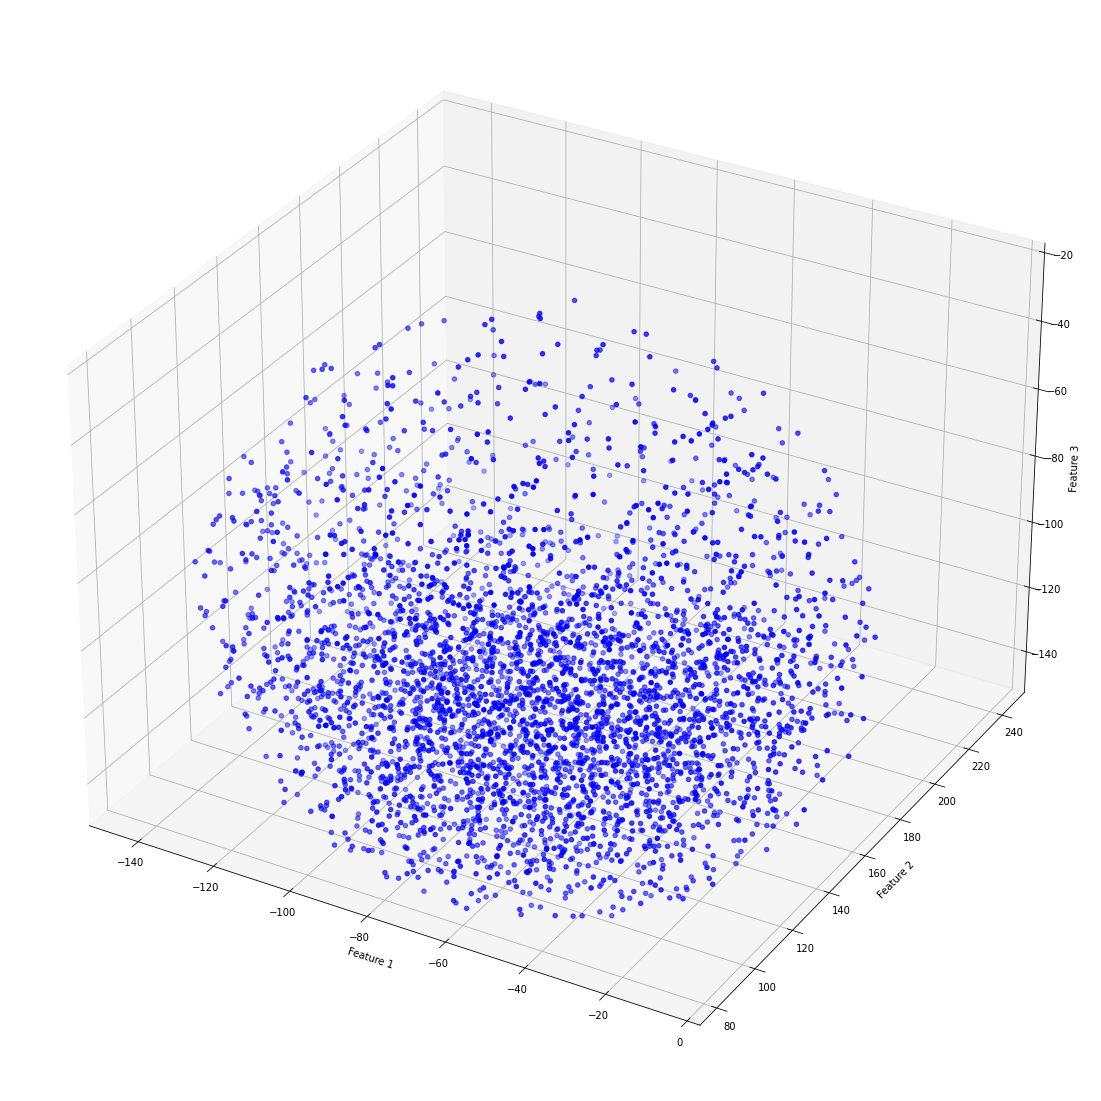

In [53]:
# Current boundaries miss outliers!
try_d2v_tsne_3d(X_tsne_d2vdbow3d, xlim=(-150, 0), ylim=(75, 250), zlim=(-150, -20), size_3d=(20, 20))

# Logistic Regression + Bag of Words

In [20]:
def try_bow(**kwargs):
    cnt_vectorizer = CountVectorizer(stop_words=en_stop, **kwargs) # en_stop because the default has problems
    X_bow = cnt_vectorizer.fit_transform(df['Text'])
    X_train_bow, X_test_bow = my_train_test_split(X_bow)

    # Scale data
    scaler_bow = StandardScaler(with_mean=False).fit(X_train_bow)
    X_train_bow_scaled = scaler_bow.transform(X_train_bow)
    X_test_bow_scaled = scaler_bow.transform(X_test_bow)
#     print(X_train_bow_scaled.shape, len(cnt_vectorizer.vocabulary_.keys()))
    
    lr_bow = LogisticRegression(max_iter=2000)
    lr_bow.fit(X_train_bow_scaled, y_train_bi)
    
    score_classifier(lr_bow, X_test_bow_scaled, big_table=False)

In [21]:
try_bow(min_df=5, ngram_range=(1, 1)) # Just unigrams

Mean accuracy: 0.8305
TP: 826, FN: 165
FP: 174, TN: 835


In [22]:
try_bow(min_df=5, ngram_range=(1, 2)) # Unigrams and bigrams

Mean accuracy: 0.848
TP: 853, FN: 157
FP: 147, TN: 843


In [23]:
try_bow(min_df=5, ngram_range=(2, 2)) # Just bigrams

Mean accuracy: 0.751
TP: 751, FN: 249
FP: 249, TN: 751


In [24]:
try_bow(min_df=5, ngram_range=(1, 3)) # Unigrams, bigrams, and trigrams

Mean accuracy: 0.845
TP: 846, FN: 156
FP: 154, TN: 844


## Logistic Regression + TFIDF

In [25]:
def try_tfidf(X_train_tfidf, X_test_tfidf):    
    lr_tfidf = LogisticRegression()
    lr_tfidf.fit(X_train_tfidf, y_train_bi)
    
    score_classifier(lr_tfidf, X_test_tfidf)

In [26]:
X_train_tfidf_1, X_test_tfidf_1 = make_tfidf(ngram_range=(1, 1))
X_train_tfidf_1_2, X_test_tfidf_1_2 = make_tfidf(ngram_range=(1, 2))
X_train_tfidf_2, X_test_tfidf_2 = make_tfidf(ngram_range=(2, 2))

(8000, 14577) 14577
(8000, 33867) 33867
(8000, 19290) 19290


In [27]:
try_tfidf(X_train_tfidf_1, X_test_tfidf_1)

Mean accuracy: 0.862
TP: 846, FN: 122
FP: 154, TN: 878
              precision    recall  f1-score   support

       False       0.85      0.87      0.86       968
        True       0.88      0.85      0.86      1032

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [28]:
try_tfidf(X_train_tfidf_1_2, X_test_tfidf_1_2)

Mean accuracy: 0.866
TP: 855, FN: 123
FP: 145, TN: 877
              precision    recall  f1-score   support

       False       0.85      0.87      0.86       978
        True       0.88      0.86      0.87      1022

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [29]:
try_tfidf(X_train_tfidf_2, X_test_tfidf_2)

Mean accuracy: 0.799
TP: 771, FN: 173
FP: 229, TN: 827
              precision    recall  f1-score   support

       False       0.77      0.82      0.79       944
        True       0.83      0.78      0.80      1056

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



In [30]:
# Choose the best tf-idf model
X_train_tfidf = X_train_tfidf_1_2
X_test_tfidf = X_test_tfidf_1_2

## Logistic Regression + Doc2Vec (DM)

In [31]:
score_classifier(LogisticRegression().fit(X_train_d2vdm, y_train_bi), X_test_d2vdm, big_table=False)

Mean accuracy: 0.848
TP: 888, FN: 192
FP: 112, TN: 808


## Logistic Regression + Doc2Vec (DBOW)

In [33]:
score_classifier(LogisticRegression().fit(X_train_d2vdbow, y_train_bi), X_test_d2vdbow, big_table=False)

Mean accuracy: 0.8615
TP: 872, FN: 149
FP: 128, TN: 851


## Logistic Regression + Doc2Vec (DM, 100 dims)

In [59]:
score_classifier(LogisticRegression().fit(X_train_d2vdm100, y_train_bi), X_test_d2vdm100, big_table=False)

Mean accuracy: 0.8445
TP: 880, FN: 191
FP: 120, TN: 809


## Logistic Regression + Doc2Vec (DBOW, 100 dims)

In [60]:
score_classifier(LogisticRegression().fit(X_train_d2vdbow100, y_train_bi), X_test_d2vdbow100, big_table=False)

Mean accuracy: 0.8585
TP: 865, FN: 148
FP: 135, TN: 852


## Logistic Regression + Word2Vec (avg)

In [40]:
score_classifier(LogisticRegression().fit(X_train_w2vavg, y_train_bi), X_test_w2vavg, big_table=False)

Mean accuracy: 0.753
TP: 760, FN: 254
FP: 240, TN: 746


# Random forests + tf-idf

In [41]:
from sklearn.ensemble import RandomForestClassifier

def try_random_forests(model_name):
    # TODO this is horrible
    X_train = eval('X_train_' + model_name)
    X_test = eval('X_test_' + model_name)
    random_forest_classifiers = [
        RandomForestClassifier(max_depth=5, random_state=1),
        RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1),
        RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200, random_state=1),
        RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200, random_state=1),
        RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300, random_state=1),
        RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300, random_state=2),
        RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300, random_state=2),
        RandomForestClassifier(max_depth=16, n_estimators=400, random_state=2),
        RandomForestClassifier(max_depth=20, n_estimators=600, random_state=1),
        RandomForestClassifier(max_depth=20, n_estimators=800, random_state=1),
    ]
    for rfc in random_forest_classifiers:
        print(rfc)
        try_classifier(rfc, X_train, X_test, big_table=False)

In [42]:
try_random_forests('tfidf')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.8095
TP: 773, FN: 154
FP: 227, TN: 846
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.816
TP: 775, FN: 143
FP: 225, TN: 857
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.828
TP: 782, FN: 126
FP: 218, TN: 874
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8335
TP: 795, FN: 128
FP: 205, TN: 872
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.837
TP: 801, FN: 127
FP: 199, TN: 873
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.83
TP: 791, FN: 131
FP: 209, TN: 869
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
              

# Random Forest + Doc2Vec (DM)

In [43]:
try_random_forests('d2vdm')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.79
TP: 805, FN: 225
FP: 195, TN: 775
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.787
TP: 795, FN: 221
FP: 205, TN: 779
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8115
TP: 820, FN: 197
FP: 180, TN: 803
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8275
TP: 838, FN: 183
FP: 162, TN: 817
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.831
TP: 837, FN: 175
FP: 163, TN: 825
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.8255
TP: 832, FN: 181
FP: 168, TN: 819
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
             

# Random Forest + Doc2Vec (DBOW)

In [44]:
try_random_forests('d2vdbow')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.809
TP: 837, FN: 219
FP: 163, TN: 781
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.8025
TP: 832, FN: 227
FP: 168, TN: 773
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8165
TP: 865, FN: 232
FP: 135, TN: 768
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8305
TP: 863, FN: 202
FP: 137, TN: 798
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.833
TP: 860, FN: 194
FP: 140, TN: 806
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.836
TP: 868, FN: 196
FP: 132, TN: 804
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
            

# Random Forest + Doc2Vec (DM, 100 dims)

In [45]:
try_random_forests('d2vdm100')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.772
TP: 770, FN: 226
FP: 230, TN: 774
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.774
TP: 767, FN: 219
FP: 233, TN: 781
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.7825
TP: 774, FN: 209
FP: 226, TN: 791
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.7935
TP: 784, FN: 197
FP: 216, TN: 803
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.8045
TP: 801, FN: 192
FP: 199, TN: 808
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.803
TP: 794, FN: 188
FP: 206, TN: 812
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
            

# Random Forest + Doc2Vec (DBOW, 100 dims)

In [46]:
try_random_forests('d2vdbow100')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.776
TP: 790, FN: 238
FP: 210, TN: 762
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.7835
TP: 803, FN: 236
FP: 197, TN: 764
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8005
TP: 804, FN: 203
FP: 196, TN: 797
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.8105
TP: 819, FN: 198
FP: 181, TN: 802
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.8215
TP: 823, FN: 180
FP: 177, TN: 820
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.818
TP: 830, FN: 194
FP: 170, TN: 806
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
           

## Random Forest + Word2Vec (avg)

In [47]:
try_random_forests('w2vavg')

RandomForestClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.72
TP: 730, FN: 290
FP: 270, TN: 710
RandomForestClassifier(max_depth=5, min_samples_leaf=5, random_state=1)
Mean accuracy: 0.7185
TP: 733, FN: 296
FP: 267, TN: 704
RandomForestClassifier(max_depth=7, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.7315
TP: 734, FN: 271
FP: 266, TN: 729
RandomForestClassifier(max_depth=9, min_samples_leaf=5, n_estimators=200,
                       random_state=1)
Mean accuracy: 0.7375
TP: 741, FN: 266
FP: 259, TN: 734
RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=300,
                       random_state=1)
Mean accuracy: 0.7445
TP: 738, FN: 249
FP: 262, TN: 751
RandomForestClassifier(max_depth=15, min_samples_leaf=10, n_estimators=300,
                       random_state=2)
Mean accuracy: 0.743
TP: 743, FN: 257
FP: 257, TN: 743
RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=300,
            

# SVM + tf-idf

In [48]:
def try_svms(model_name, max_iter=1000):
    X_train = eval('X_train_' + model_name)
    X_test = eval('X_test_' + model_name)
    svms = [
        SVC(kernel='linear', max_iter=max_iter, random_state=1),
        SVC(kernel='rbf', max_iter=max_iter, random_state=1),
        SVC(kernel='poly', degree=2, max_iter=max_iter, random_state=1),
        SVC(kernel='poly', degree=3, max_iter=max_iter, random_state=1),
        SVC(kernel='sigmoid', max_iter=max_iter, random_state=1),
    ]
    for rfc in svms:
        print(rfc)
        try_classifier(rfc, X_train, X_test, big_table=False)

In [49]:
try_svms('tfidf')

SVC(kernel='linear', max_iter=1000, random_state=1)


c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.8475
TP: 829, FN: 134
FP: 171, TN: 866
SVC(max_iter=1000, random_state=1)


c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.849
TP: 849, FN: 151
FP: 151, TN: 849
SVC(degree=2, kernel='poly', max_iter=1000, random_state=1)


c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.8325
TP: 811, FN: 146
FP: 189, TN: 854
SVC(kernel='poly', max_iter=1000, random_state=1)


c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.7505
TP: 611, FN: 110
FP: 389, TN: 890
SVC(kernel='sigmoid', max_iter=1000, random_state=1)


c:\users\yasht\fakenews\venv\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Mean accuracy: 0.843
TP: 822, FN: 136
FP: 178, TN: 864


# SVM + Doc2Vec (DM)

In [50]:
try_svms('d2vdm', max_iter=-1)

SVC(kernel='linear', random_state=1)
Mean accuracy: 0.8495
TP: 886, FN: 187
FP: 114, TN: 813
SVC(random_state=1)
Mean accuracy: 0.846
TP: 866, FN: 174
FP: 134, TN: 826
SVC(degree=2, kernel='poly', random_state=1)
Mean accuracy: 0.8365
TP: 854, FN: 181
FP: 146, TN: 819
SVC(kernel='poly', random_state=1)
Mean accuracy: 0.8375
TP: 876, FN: 201
FP: 124, TN: 799
SVC(kernel='sigmoid', random_state=1)
Mean accuracy: 0.844
TP: 883, FN: 195
FP: 117, TN: 805


In [51]:
try_d2vdm_classifier(SVC(kernel='poly', degree=4, max_iter=-1, random_state=1))

Mean accuracy: 0.819
TP: 914, FN: 276
FP: 86, TN: 724
              precision    recall  f1-score   support

       False       0.91      0.77      0.83      1190
        True       0.72      0.89      0.80       810

    accuracy                           0.82      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.84      0.82      0.82      2000



# SVM + Doc2Vec (DBOW)

In [52]:
try_svms('d2vdbow', max_iter=-1)

SVC(kernel='linear', random_state=1)
Mean accuracy: 0.8615
TP: 863, FN: 140
FP: 137, TN: 860
SVC(random_state=1)
Mean accuracy: 0.8635
TP: 875, FN: 148
FP: 125, TN: 852
SVC(degree=2, kernel='poly', random_state=1)
Mean accuracy: 0.863
TP: 860, FN: 134
FP: 140, TN: 866
SVC(kernel='poly', random_state=1)
Mean accuracy: 0.849
TP: 904, FN: 206
FP: 96, TN: 794
SVC(kernel='sigmoid', random_state=1)
Mean accuracy: 0.8555
TP: 865, FN: 154
FP: 135, TN: 846


In [53]:
try_d2vdbow_classifier(SVC(kernel='poly', degree=4, max_iter=-1, random_state=1))

Mean accuracy: 0.764
TP: 952, FN: 424
FP: 48, TN: 576
              precision    recall  f1-score   support

       False       0.95      0.69      0.80      1376
        True       0.58      0.92      0.71       624

    accuracy                           0.76      2000
   macro avg       0.76      0.81      0.76      2000
weighted avg       0.83      0.76      0.77      2000



## SVM + Word2Vec (avg)

In [55]:
try_svms('w2vavg', max_iter=-1)

SVC(kernel='linear', random_state=1)
Mean accuracy: 0.7615
TP: 766, FN: 243
FP: 234, TN: 757
SVC(random_state=1)
Mean accuracy: 0.7505
TP: 745, FN: 244
FP: 255, TN: 756
SVC(degree=2, kernel='poly', random_state=1)
Mean accuracy: 0.751
TP: 735, FN: 233
FP: 265, TN: 767
SVC(kernel='poly', random_state=1)
Mean accuracy: 0.7545
TP: 736, FN: 227
FP: 264, TN: 773
SVC(kernel='sigmoid', random_state=1)
Mean accuracy: 0.627
TP: 638, FN: 384
FP: 362, TN: 616


# Extra Trees

In [54]:
from sklearn.ensemble import ExtraTreesClassifier

def try_extra_trees(model_name):
    X_train = eval('X_train_' + model_name)
    X_test = eval('X_test_' + model_name)
    classifiers = [
        ExtraTreesClassifier(max_depth=5, n_estimators=100, random_state=1),
        ExtraTreesClassifier(max_depth=10, n_estimators=100, random_state=1),
        ExtraTreesClassifier(max_depth=15, n_estimators=100, random_state=1),
        ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1),
        ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1),
        ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1),
        ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1),
        ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1),
        ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1),
        ExtraTreesClassifier(max_depth=25, n_estimators=1000, random_state=1),
        ExtraTreesClassifier(max_depth=30, n_estimators=1500, random_state=1),
    ]
    for cls in classifiers:
        print(cls)
        try_classifier(cls, X_train, X_test, big_table=False)

## Extra Trees + tf-idf

In [55]:
try_extra_trees('tfidf')

ExtraTreesClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.802
TP: 735, FN: 131
FP: 265, TN: 869
ExtraTreesClassifier(max_depth=10, random_state=1)
Mean accuracy: 0.838
TP: 795, FN: 119
FP: 205, TN: 881
ExtraTreesClassifier(max_depth=15, random_state=1)
Mean accuracy: 0.8505
TP: 799, FN: 98
FP: 201, TN: 902
ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1)
Mean accuracy: 0.836
TP: 787, FN: 115
FP: 213, TN: 885
ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1)
Mean accuracy: 0.8495
TP: 799, FN: 100
FP: 201, TN: 900
ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1)
Mean accuracy: 0.86
TP: 824, FN: 104
FP: 176, TN: 896
ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1)
Mean accuracy: 0.864
TP: 823, FN: 95
FP: 177, TN: 905
ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1)
Mean accuracy: 0.867
TP: 821, FN: 87
FP: 179, TN: 913
ExtraTreesClassifier(max_depth=20, n_estimators=800, random_state=1

## Extra Trees + Doc2Vec (DM)

In [57]:
try_extra_trees('d2vdm')

ExtraTreesClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.7565
TP: 858, FN: 345
FP: 142, TN: 655
ExtraTreesClassifier(max_depth=10, random_state=1)
Mean accuracy: 0.7715
TP: 866, FN: 323
FP: 134, TN: 677
ExtraTreesClassifier(max_depth=15, random_state=1)
Mean accuracy: 0.7645
TP: 865, FN: 336
FP: 135, TN: 664
ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1)
Mean accuracy: 0.764
TP: 859, FN: 331
FP: 141, TN: 669
ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1)
Mean accuracy: 0.762
TP: 863, FN: 339
FP: 137, TN: 661
ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1)
Mean accuracy: 0.7715
TP: 866, FN: 323
FP: 134, TN: 677
ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1)
Mean accuracy: 0.7725
TP: 869, FN: 324
FP: 131, TN: 676
ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1)
Mean accuracy: 0.772
TP: 863, FN: 319
FP: 137, TN: 681
ExtraTreesClassifier(max_depth=20, n_estimators=800, random_

## Extra Trees + Doc2Vec (DBOW)

In [58]:
try_extra_trees('d2vdbow')

ExtraTreesClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.767
TP: 877, FN: 343
FP: 123, TN: 657
ExtraTreesClassifier(max_depth=10, random_state=1)
Mean accuracy: 0.768
TP: 886, FN: 350
FP: 114, TN: 650
ExtraTreesClassifier(max_depth=15, random_state=1)
Mean accuracy: 0.778
TP: 892, FN: 336
FP: 108, TN: 664
ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1)
Mean accuracy: 0.7685
TP: 875, FN: 338
FP: 125, TN: 662
ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1)
Mean accuracy: 0.7705
TP: 879, FN: 338
FP: 121, TN: 662
ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1)
Mean accuracy: 0.7725
TP: 887, FN: 342
FP: 113, TN: 658
ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1)
Mean accuracy: 0.785
TP: 896, FN: 326
FP: 104, TN: 674
ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1)
Mean accuracy: 0.7865
TP: 894, FN: 321
FP: 106, TN: 679
ExtraTreesClassifier(max_depth=20, n_estimators=800, random_s

## Extra Trees + Doc2Vec (DM, 100 dims)

In [59]:
try_extra_trees('d2vdm100')

ExtraTreesClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.745
TP: 842, FN: 352
FP: 158, TN: 648
ExtraTreesClassifier(max_depth=10, random_state=1)
Mean accuracy: 0.7615
TP: 867, FN: 344
FP: 133, TN: 656
ExtraTreesClassifier(max_depth=15, random_state=1)
Mean accuracy: 0.753
TP: 862, FN: 356
FP: 138, TN: 644
ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1)
Mean accuracy: 0.7525
TP: 853, FN: 348
FP: 147, TN: 652
ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1)
Mean accuracy: 0.758
TP: 854, FN: 338
FP: 146, TN: 662
ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1)
Mean accuracy: 0.7615
TP: 872, FN: 349
FP: 128, TN: 651
ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1)
Mean accuracy: 0.763
TP: 869, FN: 343
FP: 131, TN: 657
ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1)
Mean accuracy: 0.763
TP: 869, FN: 343
FP: 131, TN: 657
ExtraTreesClassifier(max_depth=20, n_estimators=800, random_st

## Extra Trees + Doc2Vec (DBOW, 100 dims)

In [60]:
try_extra_trees('d2vdbow100')

ExtraTreesClassifier(max_depth=5, random_state=1)
Mean accuracy: 0.7495
TP: 833, FN: 334
FP: 167, TN: 666
ExtraTreesClassifier(max_depth=10, random_state=1)
Mean accuracy: 0.7575
TP: 851, FN: 336
FP: 149, TN: 664
ExtraTreesClassifier(max_depth=15, random_state=1)
Mean accuracy: 0.7495
TP: 847, FN: 348
FP: 153, TN: 652
ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=1)
Mean accuracy: 0.7525
TP: 837, FN: 332
FP: 163, TN: 668
ExtraTreesClassifier(max_depth=5, n_estimators=500, random_state=1)
Mean accuracy: 0.758
TP: 840, FN: 324
FP: 160, TN: 676
ExtraTreesClassifier(max_depth=10, n_estimators=200, random_state=1)
Mean accuracy: 0.7685
TP: 860, FN: 323
FP: 140, TN: 677
ExtraTreesClassifier(max_depth=15, n_estimators=400, random_state=1)
Mean accuracy: 0.768
TP: 868, FN: 332
FP: 132, TN: 668
ExtraTreesClassifier(max_depth=15, n_estimators=500, random_state=1)
Mean accuracy: 0.767
TP: 862, FN: 328
FP: 138, TN: 672
ExtraTreesClassifier(max_depth=20, n_estimators=800, random_

# Results

In [ ]:
classifier_results